# Prison population of England and Wales

## Extracting and combining population data from downloaded Gov.uk files

In [ ]:
import glob
import pandas as pd
import re
import numpy as np
from datetime import datetime

In [ ]:
df = pd.read_excel("data/raw/2024/population_19_July_2024.ods", engine="odf")
df

In [ ]:
df = (
    pd.read_excel("data/raw/2024/population_19_July_2024.ods", 
                nrows=8, 
                skiprows=[1, 2, 3, 4],
                usecols="C,F,H",
                engine="odf")
    .dropna(how="all") # drop rows that are all NA
)
df

In [ ]:
df.iloc[:, -1]

In [ ]:
df['date'] = df.columns[-1].date()
df

In [ ]:
df.drop(columns=df.columns[-2], inplace=True)

In [ ]:
df

In [ ]:
df.columns = ["type", "population", "date"]
df

In [ ]:
df["population"] = df["population"].astype(int)
df

In [ ]:
df.replace({
    "Population": "total",
    "Population in male estate": "male",
    "Population in female estate": "female",
    "Useable Operational Capacity": "operational capacity",
    "Home Detention Curfew caseload": "HDC"
    }, 
    inplace=True)

df

### Consolidating code up to this point

In [ ]:
df = (
    pd.read_excel(
        "data/raw/2024/population_19_July_2024.ods",
        nrows=8,
        skiprows=[1, 2, 3, 4],
        usecols="C,F,H",
        engine="odf"
    )
    .dropna(how="all")  # Drop rows that are all NA
    .assign(date=lambda x: x.columns[-1].date())  # Extract date from last column name
    .pipe(lambda x: x.drop(columns=[x.columns[-2]]))  # Drop second-to-last column correctly
    .set_axis(["type", "population", "date"], axis=1)  # Rename columns
    .astype({"population": int})  # Convert population to integer
    .replace({
        "Population": "total",
        "Population in male estate": "male",
        "Population in female estate": "female",
        "Useable Operational Capacity": "operational capacity",
        "Home Detention Curfew caseload": "HDC"
    })
)
df

## Applying processing to a folder of data

In [ ]:
import pandas as pd
import glob

In [ ]:
# Define the folder path and file pattern
folder_path = "data/raw/2024/"
file_pattern = "*.ods"

# Get all matching file paths
file_paths = glob.glob(f"{folder_path}/{file_pattern}")

# Define a function to process a single file
def process_file(file_path):
    try:
        df = pd.read_excel(
            file_path,
            nrows=8,
            skiprows=[1, 2, 3, 4],
            usecols="C,F,H",
            engine="odf"
        ).dropna(how="all")  # Drop rows that are all NA

        # Debugging: Print column names before extracting the date
        print(f"Processing {file_path}, Columns: {df.columns.tolist()}")

        # Ensure the last column is a datetime-like value
        last_col = df.columns[-1]
        if not isinstance(last_col, pd.Timestamp):  # Check if it's a timestamp
            raise ValueError(f"Unexpected column format in {file_path}: {last_col}")

        return (
            df.assign(date=last_col.date())  # Extract date from last column name
            .pipe(lambda x: x.drop(columns=[x.columns[-2]]))  # Drop second-to-last column
            .set_axis(["type", "population", "date"], axis=1)  # Rename columns
            .astype({"population": int})  # Convert population to integer
            .replace({
                "Population": "total",
                "Population in male estate": "male",
                "Population in female estate": "female",
                "Useable Operational Capacity": "operational capacity",
                "Home Detention Curfew caseload": "HDC"
            })
        )
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None  # Skip problematic files

# Process all files and concatenate into one DataFrame
df_all = pd.concat([process_file(file) for file in file_paths], ignore_index=True)

# Display the final DataFrame
df_all


In [ ]:
sorted(df_all['date'].unique())

In [ ]:
len(df_all['date'].unique())

Right, I have an issue with the format of the spreadsheets changing. So I now need to investigate for differences that can be used to differentiate the type of file being processed, and adjust the processing that it goes through.

## Differentiating historic and new file formatting

In [ ]:
df_new = (
    pd.read_excel("data/raw/2024/prison-pop-16-dec-2024.ods", 
                # nrows=8, 
                # skiprows=[1, 2, 3, 4],
                # usecols="C,F,H",
                engine="odf")
    .dropna(how="all") # drop rows that are all NA
)
df_new

In [ ]:
df_old = (
    pd.read_excel("data/raw/2024/population_19_July_2024.ods", 
                # nrows=8, 
                # skiprows=[1, 2, 3, 4],
                # usecols="C,F,H",
                engine="odf")
    .dropna(how="all") # drop rows that are all NA
)
df_old

In [ ]:
df_new.shape

In [ ]:
df_old.shape

In [ ]:
import pandas as pd
import glob
from collections import Counter

folder_path = "data/raw/2024/"  # Adjust this to your actual folder
file_paths = glob.glob(f"{folder_path}/*.ods")  # Adjust extension if needed

shape_counts = Counter()

for file in file_paths:
    try:
        df = pd.read_excel(file, engine="odf").dropna(how="all")  # Read full file
        shape_counts[df.shape] += 1
    except Exception as e:
        print(f"Error reading {file}: {e}")

# Print results
print("Unique file shapes and their counts:")
for shape, count in shape_counts.items():
    print(f"Shape {shape}: {count} files")


Great, so I now know that — within this folder at least — there are only two unique dataframe shapes. I can now use this to difference to identify how the file formats should be processed. 

### Testing

#### New format
Checking the new format to determine which bits I need.

In [ ]:
df_new = pd.read_excel("data/raw/2024/prison-pop-16-dec-2024.ods", engine="odf")
df_new

There doesn't appear to be any timestamp values in here, unlike the old format. So I'm going to need to use some regex to extract the date from the correct row and column.

Let's isolate all the bits that I need from the spreadsheet first and then move on to extracting the date.

In [ ]:
df_new = (
    pd.read_excel("data/raw/2024/prison-pop-16-dec-2024.ods", engine="odf")
    .dropna(how="all") # drop rows that are all NA
)
df_new.iloc[list(range(6)), :]

In [ ]:
df_new.iloc[0, 2]

##### Extracting date

In [ ]:
import re
from datetime import datetime

In [ ]:
def extract_date_from_string(date_string):
    """Extracts a date from a string using regex and converts it to a datetime object."""
    match = re.search(r"(\d{1,2} [A-Za-z]+ \d{4})", date_string)  # Looks for '19 July 2024'
    if match:
        return datetime.strptime(match.group(1), "%d %B %Y").date()
    return None

In [ ]:
date_value = extract_date_from_string(df_new.iloc[0, 2])  # Extract date from cell
date_value

Great, that's worked as expected. Let's see if this works across all files.

In [ ]:
# Define the folder path and file pattern
folder_path = "data/raw/2024/"
file_pattern = "*.ods"

# Get all matching file paths
file_paths = glob.glob(f"{folder_path}/{file_pattern}")

def process_file(file_path):
    try:
        # Read the file
        df = pd.read_excel(file_path, engine="odf").dropna(how="all")

        # Determine format based on shape
        shape = df.shape
        if shape == (18, 8):
            format_type = "historic"
            selected_rows = list(range(7))  # First 7 rows contain relevant data
            selected_cols = [2, 5]  # Adjust based on actual needed columns
            date_value = extract_date_from_string(df.iloc[0, 2])  # Extract date from cell
        elif shape == (25, 9):
            format_type = "new"
            selected_rows = list(range(6))  # First 6 rows contain relevant data
            selected_cols = [2, 4, 6, 7, 8]  # Adjust for new format
            date_value = extract_date_from_string(df.iloc[0, 2])  # Extract date from cell
            if date_value is None:
                raise ValueError(f"Could not extract date from {file_path}")
        else:
            raise ValueError(f"Unexpected format in {file_path}: {shape}")
        
        print(f"Processing {date_value} ({format_type} format)")
    
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None  # Skip problematic files

In [ ]:
for file in file_paths:
    process_file(file)

Extraction of dates is working perfectly by the looks of things.

##### Cleaning and shaping dataframe
Temporarily redefining `process_file` method to test how the new format needs to be processed.

In [ ]:
# Define the folder path and file pattern
folder_path = "data/raw/2024/"
file_pattern = "*.ods"

# Get all matching file paths
file_paths = glob.glob(f"{folder_path}/{file_pattern}")

def extract_date_from_string(date_string):
    """Extracts a date from a string using regex and converts it to a datetime object."""
    match = re.search(r"(\d{1,2} [A-Za-z]+ \d{4})", date_string)  # Looks for '19 July 2024'
    if match:
        return datetime.strptime(match.group(1), "%d %B %Y").date()
    return None

def process_file(file_path):
    try:
        # Read the file
        df = pd.read_excel(file_path, engine="odf").dropna(how="all")

        # Determine format based on shape
        shape = df.shape
        if shape == (18, 8):
            format_type = "historic"
            selected_rows = list(range(7))  # First 7 rows contain relevant data
            selected_cols = [2, 5]  # Adjust based on actual needed columns
        elif shape == (25, 9):
            format_type = "new"
            selected_rows = list(range(6))  # First 6 rows contain relevant data
            selected_cols = [2, 4, 6, 7, 8]  # Adjust for new format

        else:
            raise ValueError(f"Unexpected format in {file_path}: {shape}")

        print(f"Processing {file_path} as {format_type} format")

        # Extract relevant columns
        df = df.iloc[selected_rows, selected_cols]  # Select rows and columns

        return (
            df
            .assign(date=extract_date_from_string(df.iloc[0, 0]))  # Assign extracted date
            # .pipe(lambda x: x.drop(columns=[x.columns[-2]]))  # Drop last column before renaming
            # .set_axis(["type", "population", "date"], axis=1)
            # .astype({"population": int})
            # .replace({
            #     "Population": "total",
            #     "Population in male estate": "male",
            #     "Population in female estate": "female",
            #     "Useable Operational Capacity": "operational capacity",
            #     "Home Detention Curfew caseload": "HDC"
            # })
        )

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None  # Skip problematic files

In [ ]:
test_new_df = process_file("data/raw/2024/prison-pop-16-dec-2024.ods")
test_new_df

This seems to be working. Now need to pivot from wide to long, then sort out the column names.

In [ ]:
# Select relevant rows (rows 4, 5, 6, 8) and all columns
test_new_df.loc[[4, 5, 6, 8], :]

In [ ]:
test_new_df = test_new_df.loc[[4, 5, 6, 8], :].copy()

In [ ]:
test_new_df.columns = ["type", "Total", "Adult Male", "Female", "YCS", "date"]
test_new_df

In [ ]:
(test_new_df
    .melt(id_vars=["date", "type"], var_name="group", value_name="value")
    .replace(
        {"type": {
            "Population": "prison",
            "Useable Operational Capacity": "operational_capacity",
            "Headroom": "headroom",
            "Home Detention Curfew caseload": "hdc"
        },
        "group": {
            "Total": "total",
            "Adult Male": "male",
            "Female": "female",
            "YCS": "youth"
        }}
    )
    .assign(value=lambda df: pd.to_numeric(df["value"], errors="coerce").astype("Int64"))  # Convert value to numeric
    .loc[:, ["date", "group", "type", "value"]]  # Reorder columns
)


#### Old format
Now to double check which bits of the historic format files I need.

In [ ]:
test_old_df = process_file("data/raw/2024/prison-pop-9-feb-2024.ods")
test_old_df

In [ ]:
# Define the folder path and file pattern
folder_path = "data/raw/2024/"
file_pattern = "*.ods"

# Get all matching file paths
file_paths = glob.glob(f"{folder_path}/{file_pattern}")

def extract_date_from_string(date_string):
    """Extracts a date from a string using regex and converts it to a datetime object."""
    match = re.search(r"(\d{1,2} [A-Za-z]+ \d{4})", date_string)  # Looks for '19 July 2024'
    if match:
        return datetime.strptime(match.group(1), "%d %B %Y").date()
    return None

def process_file(file_path):
    try:
        # Read the file
        df = pd.read_excel(file_path, engine="odf").dropna(how="all")

        # Determine format based on shape
        shape = df.shape
        if shape == (18, 8):
            format_type = "historic"
            selected_rows = list(range(7))  # First 7 rows contain relevant data
            selected_cols = [2, 5]  # Adjust based on actual needed columns
        elif shape == (25, 9):
            format_type = "new"
            selected_rows = list(range(6))  # First 6 rows contain relevant data
            selected_cols = [2, 4, 6, 7, 8]  # Adjust for new format
            if date_value is None:
                raise ValueError(f"Could not extract date from {file_path}")
        else:
            raise ValueError(f"Unexpected format in {file_path}: {shape}")

        print(f"Processing {file_path} as {format_type} format")

        # Extract relevant columns
        df = df.iloc[selected_rows, selected_cols]  # Select rows and columns

        return (
            df
            .assign(date=extract_date_from_string(df.iloc[0, 0]))  # Assign extracted date
            # .pipe(lambda x: x.drop(columns=[x.columns[-2]]))  # Drop last column before renaming
            # .set_axis(["type", "population", "date"], axis=1)
            # .astype({"population": int})
            # .replace({
            #     "Population": "total",
            #     "Population in male estate": "male",
            #     "Population in female estate": "female",
            #     "Useable Operational Capacity": "operational capacity",
            #     "Home Detention Curfew caseload": "HDC"
            # })
        )

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None  # Skip problematic files

In [ ]:
import pandas as pd
import glob
import re
from datetime import datetime

# Define the folder path and file pattern
folder_path = "data/raw/2024/"
file_pattern = "*.ods"

# Get all matching file paths
file_paths = glob.glob(f"{folder_path}/{file_pattern}")

def extract_date_from_string(date_string):
    """Extracts a date from a string using regex and converts it to a datetime object."""
    match = re.search(r"(\d{1,2} [A-Za-z]+ \d{4})", date_string)  # Looks for '9 February 2024'
    if match:
        return datetime.strptime(match.group(1), "%d %B %Y").date()
    return None

def process_historic_file(file_path):
    """Processes historic format spreadsheets to match new format structure."""
    
    # Read the file
    df = pd.read_excel(file_path, engine="odf").dropna(how="all")

    format_type = "historic"
    selected_rows = list(range(7))  # First 7 rows contain relevant data
    selected_cols = [2, 5]  # Adjust based on actual needed columns

    df = df.iloc[selected_rows, selected_cols]  # Select rows and columns
    
    # Extract date
    date = extract_date_from_string(df.iloc[0, 0])
    if date is None:
        raise ValueError(f"Could not extract date from {file_path}")
    
    # Select relevant rows and columns
    df.columns = ["type", "group_value"]  # Rename columns for clarity
    
    # Mapping type values to match new format
    type_mapping = {
        "Population": "prison",  # This will map 'Population' to 'prison'
        "Useable Operational Capacity": "operational_capacity",
        "Home Detention Curfew caseload": "hdc"
    }
    
    # Mapping group values to match new format
    group_mapping = {
        "Population in male estate": "male",
        "Population in female estate": "female",
        "Population": "total"  # "Population" will be assigned 'total'
    }
    
    # Apply mappings (group and type)
    df["type"] = df["type"].replace(type_mapping)
    df["group"] = df["group_value"].replace(group_mapping)
    
    # Reassign 'prison' for both male and female estate populations (same type for both)
    df.loc[df["group_value"].isin(["Population in male estate", "Population in female estate"]), "type"] = "prison"
    
    # Ensure 'operational_capacity' and 'hdc' get 'total' as their group
    df.loc[df["type"].isin(["operational_capacity", "hdc"]), "group"] = "total"
    
    # Assign extracted date and cleanup
    df = (
        df.assign(date=date)  # Assign extracted date
        .rename(columns={"group_value": "value"})  # Rename column for consistency
        .assign(value=lambda x: pd.to_numeric(x["value"], errors="coerce").astype("Int64"))  # Convert values to numeric
        .loc[:, ["date", "group", "type", "value"]]  # Reorder columns (keep all rows)
        .loc[4:]  # Keep rows from index 4 onwards (after dropping unwanted metadata)
    )

    return df

In [ ]:
# Testing the updated function
test_old_df = process_historic_file("data/raw/2024/prison-pop-9-feb-2024.ods")
test_old_df

In [ ]:
test_old_df['type'].unique()

In [ ]:
import pandas as pd
import glob
import re
from datetime import datetime

# Define the folder path and file pattern
folder_path = "data/raw/2024/"
file_pattern = "*.ods"

# Get all matching file paths
file_paths = glob.glob(f"{folder_path}/{file_pattern}")

def extract_date_from_string(date_string):
    """Extracts a date from a string using regex and converts it to a datetime object."""
    match = re.search(r"(\d{1,2} [A-Za-z]+ \d{4})", date_string)  # Looks for '9 February 2024'
    if match:
        return datetime.strptime(match.group(1), "%d %B %Y").date()
    return None

def process_historic_file(file_path):
    """Processes historic format spreadsheets to match new format structure."""
    
    # Read the file
    df = pd.read_excel(file_path, engine="odf").dropna(how="all")

    # Select relevant rows and columns
    selected_rows = list(range(7))  # First 7 rows contain relevant data
    selected_cols = [2, 5]  # Adjust based on actual needed columns
    df = df.iloc[selected_rows, selected_cols]

    # Extract date
    date = extract_date_from_string(df.iloc[0, 0])
    if date is None:
        raise ValueError(f"Could not extract date from {file_path}")
    
    # Rename columns for clarity
    df.columns = ["type", "group_value"]
    
    # Mapping type values to match new format for other cases
    type_mapping = {
        "Population": "prison",  # This will map 'Population' to 'prison'
        "Useable Operational Capacity": "operational_capacity",
        "Home Detention Curfew caseload": "hdc"
    }
    
    # Apply type mapping for other cases
    df["type"] = df["type"].replace(type_mapping)

    # Apply 'total' to group for 'operational_capacity' and 'hdc'
    df.loc[df["type"].isin(["prison", "operational_capacity", "hdc"]), "group"] = "total"

    # Apply transformations:
    # 1. If 'type' == "Population in male estate", 'group' should be "male" and 'type' should be "prison"
    df.loc[df["type"] == "Population in male estate", "group"] = "male"
    df.loc[df["type"] == "Population in male estate", "type"] = "prison"
    
    # 2. If 'type' == "Population in female estate", 'group' should be "female" and 'type' should be "prison"
    df.loc[df["type"] == "Population in female estate", "group"] = "female"
    df.loc[df["type"] == "Population in female estate", "type"] = "prison"
    
    # Assign extracted date and cleanup
    df = (
        df.assign(date=date)  # Assign extracted date
        .rename(columns={"group_value": "value"})  # Rename column for consistency
        .assign(value=lambda x: pd.to_numeric(x["value"], errors="coerce").astype("Int64"))  # Convert values to numeric
        .loc[:, ["date", "group", "type", "value"]]  # Reorder columns (keep all rows)
        .loc[4:]  # Keep rows from index 4 onwards (after dropping unwanted metadata)
    )

    return df

# Testing the updated function
test_old_df = process_historic_file("data/raw/2024/prison-pop-9-feb-2024.ods")
test_old_df

Right, this looks like the correct output now. So let's now consolidate.

### Defining processing functions for new and old formats

In [ ]:
# Define the folder path and file pattern
folder_path = "data/raw/2024/"
file_pattern = "*.ods"

# Get all matching file paths
file_paths = glob.glob(f"{folder_path}/{file_pattern}")

In [4]:
def extract_date_from_string(date_string):
    """Extracts a date from a string using regex and converts it to a datetime object."""
    match = re.search(r"(\d{1,2} [A-Za-z]+ \d{4})", date_string)  # Looks for '19 July 2024'
    if match:
        return datetime.strptime(match.group(1), "%d %B %Y").date()
    return None

In [5]:
def process_historic_file(file_path):
    """Processes historic format spreadsheets to match new format structure."""
    try:
        # Read the file
        df = file_path

        # Select relevant rows and columns
        selected_rows = list(range(7))  # First 7 rows contain relevant data
        selected_cols = [2, 5]  # Adjust based on actual needed columns
        df = df.iloc[selected_rows, selected_cols]

        # Extract date
        date = extract_date_from_string(df.iloc[0, 0])
        if date is None:
            raise ValueError(f"Could not extract date from {file_path}")
        
        # Rename columns for clarity
        df.columns = ["type", "group_value"]
        
        # Step 1: Assign 'total' to group for original 'prison' type
        df.loc[df["type"] == "Population", "group"] = "total"
        df.loc[df["type"] == "Population", "type"] = "prison"

        # Step 2: Assign correct group values for male and female estate
        df.loc[df["type"] == "Population in male estate", "group"] = "male"
        df.loc[df["type"] == "Population in female estate", "group"] = "female"

        # Step 3: Change type for male and female estate to 'prison'
        df.loc[df["type"].isin(["Population in male estate", "Population in female estate"]), "type"] = "prison"
        
        # Step 4: Map other types to their new format
        type_mapping = {
            "Useable Operational Capacity": "operational_capacity",
            "Home Detention Curfew caseload": "hdc"
        }
        df["type"] = df["type"].replace(type_mapping)

        # Step 5: Ensure 'total' is assigned to operational capacity and HDC
        df.loc[df["type"].isin(["operational_capacity", "hdc"]), "group"] = "total"
        
        # Assign extracted date and cleanup
        df = (
            df.assign(date=date)  # Assign extracted date
            .rename(columns={"group_value": "value"})  # Rename column for consistency
            .assign(value=lambda x: pd.to_numeric(x["value"], errors="coerce").astype("Int64"))  # Convert values to numeric
            .loc[:, ["date", "group", "type", "value"]]  # Reorder columns (keep all rows)
            .loc[4:]  # Keep rows from index 4 onwards (after dropping unwanted metadata)
        )

        return df
    
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

In [6]:
def process_file(file_path):
    try:
        # Read the file
        df = pd.read_excel(file_path, engine="odf").dropna(how="all")

        # Determine format based on shape
        shape = df.shape
        if shape == (18, 8):
            format_type = "historic"
            df = process_historic_file(df)
            
        elif shape == (25, 9):
            format_type = "new"

            # Select relevant rows and columns
            selected_rows = list(range(6))  # First 6 rows contain relevant data
            selected_cols = [2, 4, 6, 7, 8]  # Adjust for new format
            df = df.iloc[selected_rows, selected_cols]

            # Extract date
            date = extract_date_from_string(df.iloc[0, 0])
            if date is None:
                raise ValueError(f"Could not extract date from {file_path}")
        
            df = (
                df
                .assign(date=extract_date_from_string(df.iloc[0, 0]))  # Assign extracted date
                .loc[[4, 5, 6, 8], :]
                .rename(columns=dict(zip(df.columns, ["type", "total", "male", "female", "youth", "date"])))
                .melt(id_vars=["date", "type"], var_name="group", value_name="value")
                .replace({
                    "type": {
                        "Population": "prison",
                        "Useable Operational Capacity": "operational_capacity",
                        "Headroom": "headroom",
                        "Home Detention Curfew caseload": "hdc"
                    },
                })
                .assign(value=lambda df: pd.to_numeric(df["value"], errors="coerce").astype("Int64"))  # Convert value to numeric
                .loc[:, ["date", "group", "type", "value"]]  # Reorder columns

            )

        return (
            df
            .dropna(how='any')  # Drop rows with missing values
            .sort_values("group")
            .reset_index(drop=True)
            )
    
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None  # Skip problematic files
    
# Testing the updated functions
df = process_file("data/raw/2024/prison-pop-16-dec-2024.ods")
df

,date,group,type,value
0,2024-12-16,female,prison,3485
1,2024-12-16,female,operational_capacity,3853
2,2024-12-16,female,headroom,368
3,2024-12-16,male,prison,82114
4,2024-12-16,male,operational_capacity,84387
5,2024-12-16,male,headroom,2273
6,2024-12-16,total,prison,85960
7,2024-12-16,total,operational_capacity,88692
8,2024-12-16,total,headroom,2732
9,2024-12-16,total,hdc,4101


In [7]:
df = process_file("data/raw/2024/prison-pop-9-feb-2024.ods")
df

,date,group,type,value
0,2024-02-09,female,prison,3623
1,2024-02-09,male,prison,84359
2,2024-02-09,total,prison,87982
3,2024-02-09,total,operational_capacity,89099
4,2024-02-09,total,hdc,2189


That seems to be now working as expected. Now to test a folder.

### Putting it all together

In [2]:
import glob
import pandas as pd
import re
import numpy as np
from datetime import datetime

In [3]:
# Define the folder path and file pattern
folder_path = "data/raw/2024/"
file_pattern = "*.ods"

# Get all matching file paths
file_paths = glob.glob(f"{folder_path}/{file_pattern}")

In [8]:
# Process all files and concatenate into one DataFrame
df_all = pd.concat([process_file(file) for file in file_paths], ignore_index=True)

# Display the final DataFrame
df_all

,date,group,type,value
0,2024-08-09,female,prison,3596
1,2024-08-09,male,prison,83900
2,2024-08-09,total,prison,87496
3,2024-08-09,total,operational_capacity,88936
4,2024-08-09,total,hdc,2645
...,...,...,...,...
343,2024-05-10,female,prison,3642
344,2024-05-10,male,prison,84049
345,2024-05-10,total,prison,87691
346,2024-05-10,total,operational_capacity,88929


In [ ]:
df = (
    df_all
    .sort_values(["date", "group", "type"])
    .reset_index(drop=True)
    )
df

,date,group,type,value
0,2024-01-05,female,prison,3571
1,2024-01-05,male,prison,83877
2,2024-01-05,total,hdc,2167
3,2024-01-05,total,operational_capacity,88956
4,2024-01-05,total,prison,87448
...,...,...,...,...
343,2024-12-30,total,operational_capacity,88688
344,2024-12-30,total,prison,85618
345,2024-12-30,youth,headroom,97
346,2024-12-30,youth,operational_capacity,452


group
female    Axes(0.125,0.2;0.775x0.68)
male      Axes(0.125,0.2;0.775x0.68)
total     Axes(0.125,0.2;0.775x0.68)
youth     Axes(0.125,0.2;0.775x0.68)
dtype: object

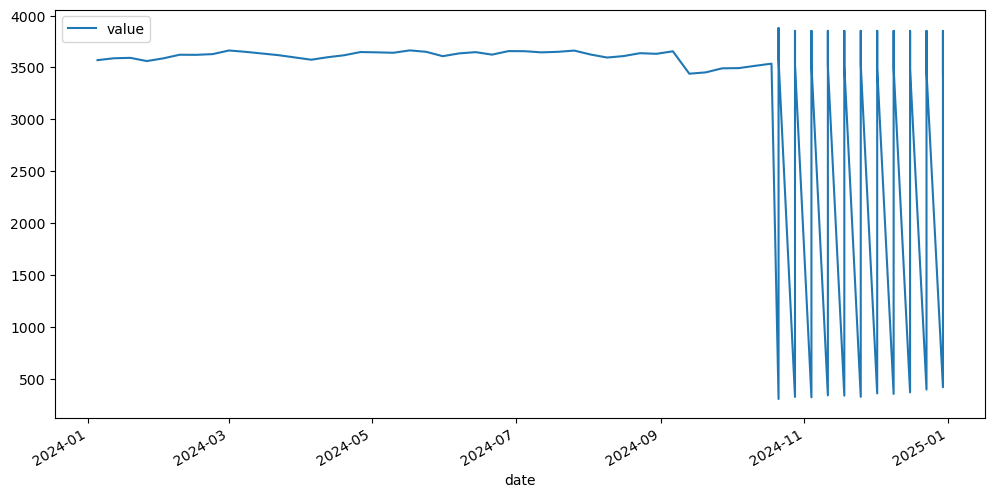

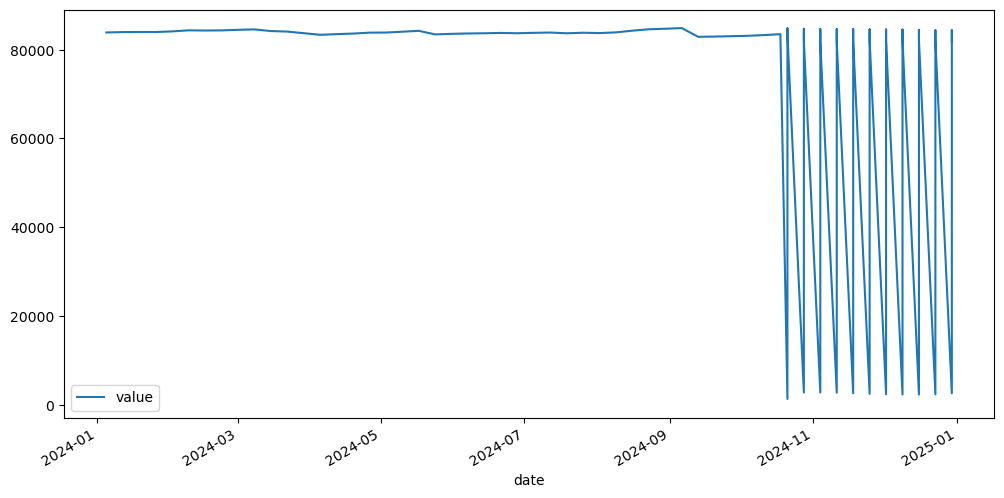

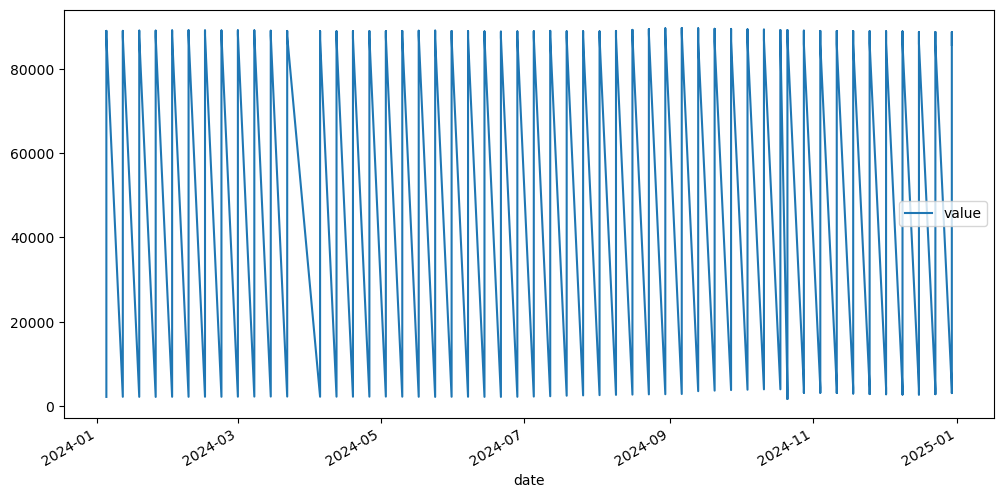

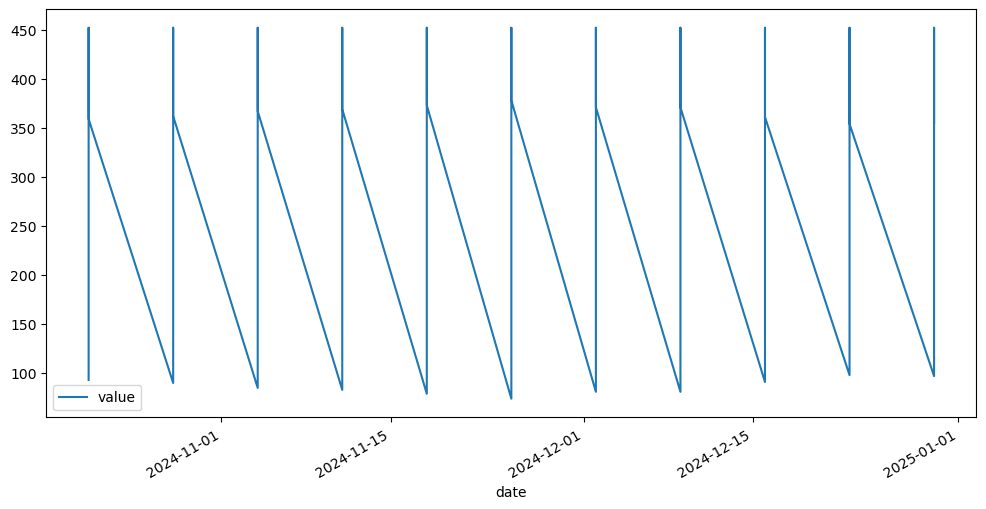

In [21]:
df.groupby("group").plot(x="date", y="value", kind="line", figsize=(12, 6))

Okay, definitely something weird going on with some of the newer data which will need some further investigation

In [25]:
filt = df["group"] == "female"
df[filt]

,date,group,type,value
0,2024-01-05,female,prison,3571
5,2024-01-12,female,prison,3589
10,2024-01-19,female,prison,3593
15,2024-01-26,female,prison,3562
20,2024-02-02,female,prison,3588
...,...,...,...,...
323,2024-12-23,female,operational_capacity,3853
324,2024-12-23,female,prison,3458
335,2024-12-30,female,headroom,417
336,2024-12-30,female,operational_capacity,3853


Ahhhhhhhh, it also needs filtering by type == 'prison'

In [26]:
filt = df["group"] == "female"
filt2 = df["type"] == "prison"
female_prison = df[filt & filt2]
female_prison

,date,group,type,value
0,2024-01-05,female,prison,3571
5,2024-01-12,female,prison,3589
10,2024-01-19,female,prison,3593
15,2024-01-26,female,prison,3562
20,2024-02-02,female,prison,3588
25,2024-02-09,female,prison,3623
30,2024-02-16,female,prison,3622
35,2024-02-23,female,prison,3629
40,2024-03-01,female,prison,3664
45,2024-03-08,female,prison,3651


<Axes: xlabel='date'>

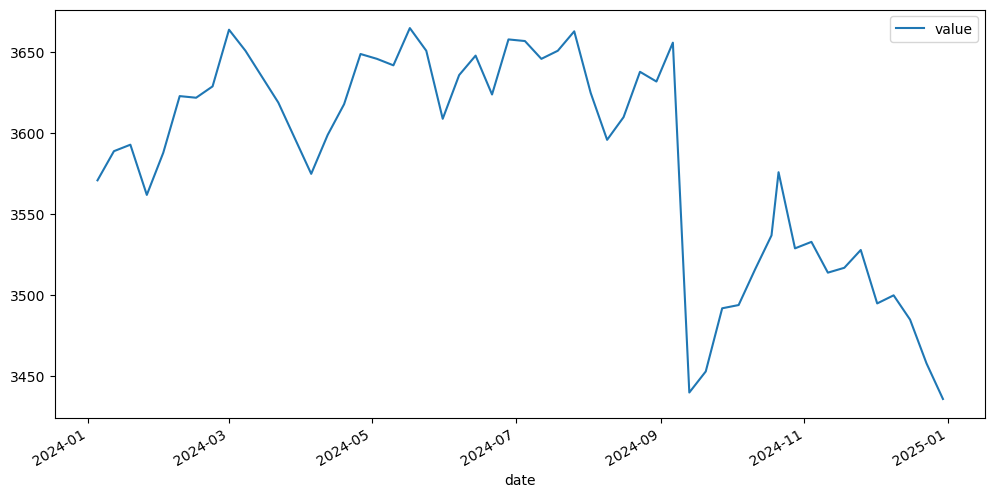

In [ ]:
female_prison.plot(x="date", y="value", kind="line", figsize=(12, 6), )

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    348 non-null    object
 1   group   348 non-null    object
 2   type    348 non-null    object
 3   value   348 non-null    Int64 
dtypes: Int64(1), object(3)
memory usage: 11.3+ KB


In [20]:
df["date"] = pd.to_datetime(df["date"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    348 non-null    datetime64[ns]
 1   group   348 non-null    object        
 2   type    348 non-null    object        
 3   value   348 non-null    Int64         
dtypes: Int64(1), datetime64[ns](1), object(2)
memory usage: 11.3+ KB
